In [1]:
import torch, torchvision
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import transforms as T
import os, shutil
from matplotlib import pyplot as plt
import sklearn as sk
from glob import glob
from tqdm import tqdm
from PIL import Image
import numpy as np
import torchmetrics
import timm
from time import time

# Importing Dataset

In [3]:
from kagglehub import kagglehub
dataset_path = kagglehub.dataset_download("tanlikesmath/the-oxfordiiit-pet-dataset")
shutil.rmtree(f"{dataset_path}/images/images", ignore_errors = True)
print(dataset_path)

C:\Users\Nodir\.cache\kagglehub\datasets\tanlikesmath\the-oxfordiiit-pet-dataset\versions\1


In [4]:
import torch
torch.cuda.is_available()

True

# Creating Custom Dataset

In [80]:
class CustomDataset(Dataset):
    def __init__(self, data_path, img_formats = ['.jpg', '.jpeg', '.bmp'], transformations = None):
        
        super().__init__()
        self.transformations = transformations
        self.img_pathes = glob(f"{data_path}/images/*{[image_format for image_format in img_formats]}")
        self.get_data_info()

    def __len__(self): return(len(self.img_pathes))

    def get_data_info(self):
        numbering, self.class_names, self.data_quantity = 0, {}, {}
        
        for one_img_path in self.img_pathes: 
            class_name = self.get_class_name(self.class_name_detection(one_img_path))
            if class_name not in self.class_names: 
                self.class_names[class_name] = numbering
                numbering += 1
            if class_name not in self.data_quantity:
                self.data_quantity[class_name] = 1
            else: self.data_quantity[class_name] += 1
        # print(self.class_names)
        # print(self.data_quantity)
        
    def get_class_name(self, class_name):
        class_name_list = ""
        for idx, char in enumerate(class_name):
          if char.isalpha():
              class_name_list += char
              next_char = class_name[idx+1]
              if (next_char == "_") and (not class_name[idx + 2].isdigit()):
                  class_name_list += "_"
    
        return class_name_list

        

    def class_name_detection(self, one_img_path):
        return os.path.splitext(os.path.basename(one_img_path))[0]

    def __getitem__(self, idx):
        one_img_path = self.img_pathes[idx]
        class_name = self.get_class_name(self.class_name_detection(one_img_path))
        item_class_name = self.class_names[class_name]
        pic = Image.open(one_img_path).convert("RGB")
        if self.transformations: pic = self.transformations(pic)
        return pic, item_class_name

dataset_path = "/Users/Nodir/.cache/kagglehub/datasets/tanlikesmath/the-oxfordiiit-pet-dataset/versions/1"
mean, std, img_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224                  
tfs = T.Compose([T.Resize((img_size, img_size)), T.ToTensor(), T.Normalize(mean=mean, std=std)])                
ds = CustomDataset(data_path = dataset_path, transformations = tfs)     

    

{'Abyssinian': 0, 'american_bulldog': 1, 'american_pit_bull_terrier': 2, 'basset_hound': 3, 'beagle': 4, 'Bengal': 5, 'Birman': 6, 'Bombay': 7, 'boxer': 8, 'British_Shorthair': 9, 'chihuahua': 10, 'Egyptian_Mau': 11, 'english_cocker_spaniel': 12, 'english_setter': 13, 'german_shorthaired': 14, 'great_pyrenees': 15, 'havanese': 16, 'japanese_chin': 17, 'keeshond': 18, 'leonberger': 19, 'Maine_Coon': 20, 'miniature_pinscher': 21, 'newfoundland': 22, 'Persian': 23, 'pomeranian': 24, 'pug': 25, 'Ragdoll': 26, 'Russian_Blue': 27, 'saint_bernard': 28, 'samoyed': 29, 'scottish_terrier': 30, 'shiba_inu': 31, 'Siamese': 32, 'Sphynx': 33, 'staffordshire_bull_terrier': 34, 'wheaten_terrier': 35, 'yorkshire_terrier': 36}


# DataLoaders

In [57]:
def create_dataloaders(data_path, transformations, bs ,split = [0.9, 0.05, 0.05]):
    ds = CustomDataset(data_path = dataset_path, transformations = tfs)
    total_len = len(ds)
    tr_len = int(total_len * split[0])
    vl_len = int(total_len * split[1])
    ts_len = total_len - (vl_len + tr_len)
    print(len(ds))
    tr_ds, vl_ds, ts_ds = random_split(dataset = ds, lengths = [tr_len, vl_len, ts_len])

    tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True)
    vl_dl = DataLoader(vl_ds, batch_size = bs, shuffle = False)
    ts_dl = DataLoader(ts_ds, batch_size = 1, shuffle = False)
    return tr_dl, vl_dl, ts_dl, ds.class_names
tr_dl, vl_dl, ts_dl, class_names = create_dataloaders(data_path = dataset_path, transformations = tfs, bs = 32)

for idx, pic in enumerate(ds):
    if idx == 1: break
    print(ds[idx])
print(len(tr_dl))
print(len(vl_dl))
print(len(ts_dl))
print(class_names)

7390
(tensor([[[-1.6042, -1.6042, -1.5870,  ..., -1.3473, -1.3815, -1.3987],
         [-1.6213, -1.5870, -1.5699,  ..., -1.3302, -1.3473, -1.3815],
         [-1.6213, -1.5870, -1.5528,  ..., -1.3130, -1.3302, -1.3644],
         ...,
         [-1.9124, -1.8953, -1.8953,  ..., -1.7925, -1.8268, -1.8439],
         [-1.9295, -1.9295, -1.9124,  ..., -1.8268, -1.8439, -1.8610],
         [-1.9295, -1.9467, -1.9124,  ..., -1.8610, -1.8610, -1.8610]],

        [[-1.3704, -1.3704, -1.3529,  ..., -1.1078, -1.1429, -1.1604],
         [-1.3880, -1.3529, -1.3354,  ..., -1.0903, -1.1078, -1.1429],
         [-1.3880, -1.3529, -1.3179,  ..., -1.0728, -1.0903, -1.1253],
         ...,
         [-1.7031, -1.6856, -1.6856,  ..., -1.5630, -1.5980, -1.6155],
         [-1.7206, -1.7206, -1.7031,  ..., -1.5980, -1.6155, -1.6331],
         [-1.7206, -1.7381, -1.7031,  ..., -1.6331, -1.6331, -1.6331]],

        [[-1.3339, -1.3339, -1.3164,  ..., -1.1073, -1.1421, -1.1596],
         [-1.3513, -1.3164, -1.2990,  .

# Checkpoint

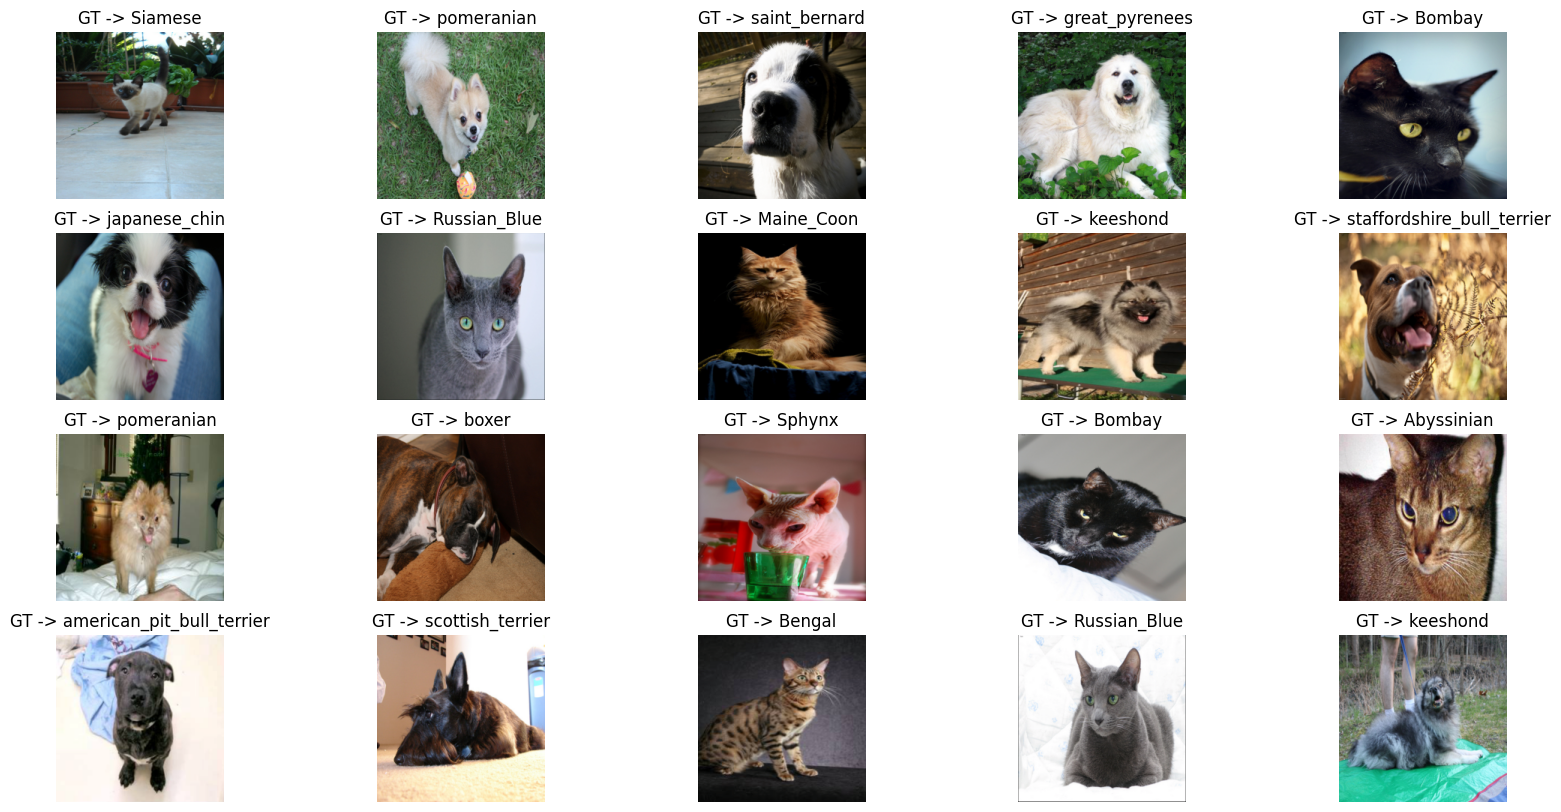

In [10]:
def tensor_2_pic(t, t_type = 'rgb'):   
    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])
   
    invTrans = gray_tfs if t_type == 'gray' else rgb_tfs
    
    return (invTrans(t)*255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == 'gray' else (invTrans(t)*255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)
import random
def visualize(data, num_pics, num_rows, class_names = None, cmap = None):
    assert cmap in ['rgb', 'gray']
    if cmap == 'rgb': cmap = 'viridis'
    plt.figure(figsize = (20,10))
    indexes = [random.randint(0, len(data)-1) for _ in range(num_pics)]
    for idx, indeks in enumerate(indexes):
        pic, gts = data[indeks]
        # print(type(pic))
        # print(type(gts))
        # print(type(idx))
        # print(type(indeks))
        # break
        plt.subplot(num_rows, num_pics//num_rows, idx+1)
        if cmap: plt.imshow(tensor_2_pic(pic, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_pic(pic))
        plt.axis("off")
        if class_names is not None: plt.title(f"GT -> {class_names[gts]}")
        else: plt.title(f"GT -> {gts}")
            
visualize(tr_dl.dataset, num_pics = 20, num_rows = 4, cmap = 'rgb', class_names = list(class_names.keys()))


# Class quantities

C:\Users\Nodir\AppData\Local\Temp\ipykernel_5440\4056960.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names, rotation = 60)


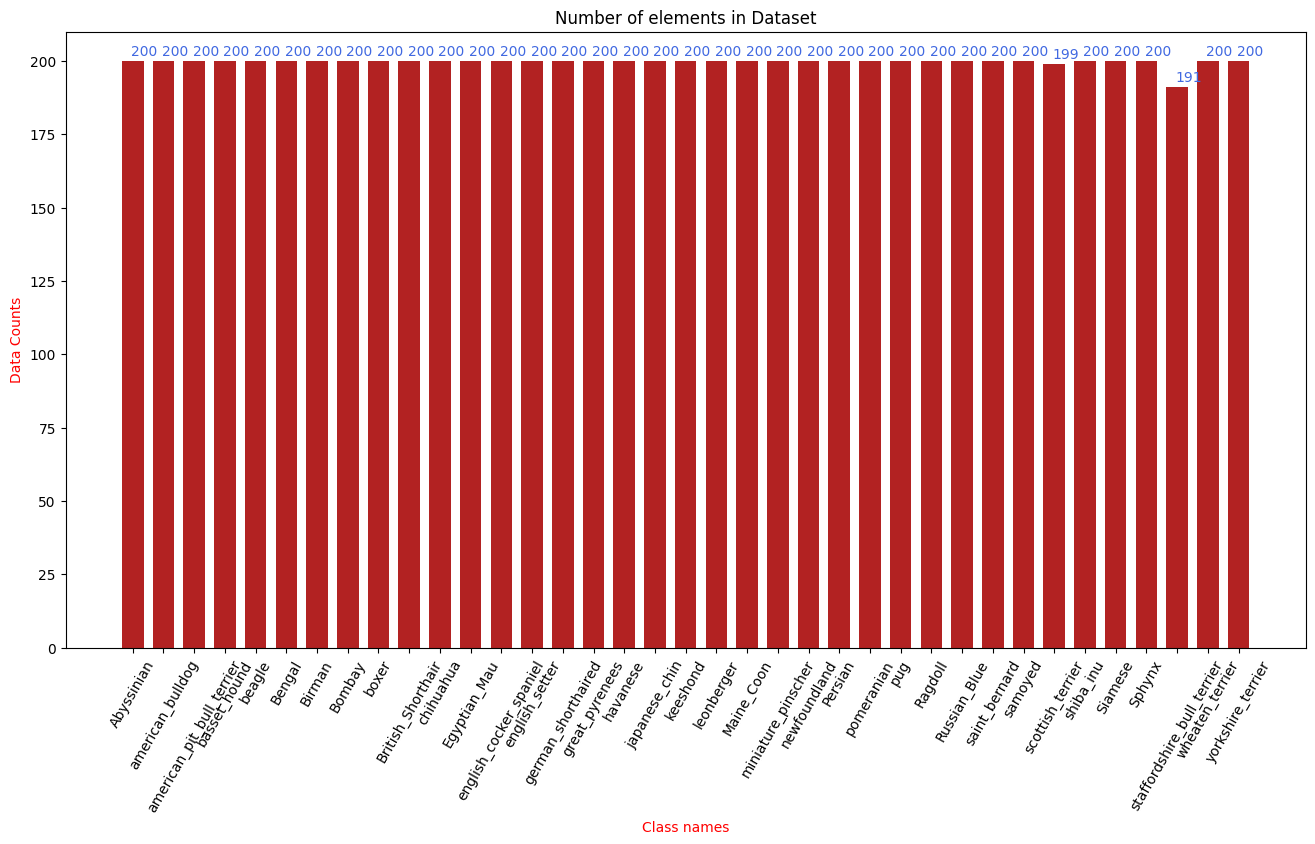

In [12]:
tfs = T.Compose([T.ToTensor(), T.Normalize(std = std, mean = mean), T.Resize((img_size, img_size))])
def data_analysis(data_path, transformations):
    ds = CustomDataset(data_path = dataset_path, transformations = tfs)
    data_quantity, text_width, width = ds.data_quantity, 0.05, 0.7
    text_height = 2
    class_names = list(data_quantity.keys()); counts = list(data_quantity.values())
    fig, ax = plt.subplots(figsize=(16, 8))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width, color = 'firebrick')
    ax.set_xlabel("Class names", color = "red")
    ax.set_xticklabels(class_names, rotation = 60)
    ax.set(xticks = indices, xticklabels = class_names)
    ax.set_ylabel("Data Counts", color = "red")
    ax.set_title("Number of elements in Dataset")
    for i, v in enumerate(counts): ax.text(i - text_width, v + text_height, str(v) , color = "royalblue")
data_analysis(data_path = dataset_path, transformations = tfs)

# Train and Validation

In [14]:
class TrainValidation:
    
    def  __init__(self, model, class_names, tr_dl, vl_dl,device, epochs, lr = 3e-4, patience = 5, folder_2_save = "best_model"):
        
        self.model = model
        self.class_names = class_names
        self.tr_dl = tr_dl
        self.vl_dl = vl_dl
        self.epochs = epochs
        self.lr = lr
        self.patience = patience
        self.device = device
        self.not_improved = 0
        self.best_acc = 0
        self.device = device
        self.num_classes = len(class_names)
        import timm

      
        self.model = timm.create_model(model, pretrained = True, num_classes = self.num_classes).to(device)
        self.optimizer = torch.optim.Adam(params = self.model.parameters(), lr=lr)
        self.loss_fn = torch.nn.CrossEntropyLoss()

     
        self.train_losses = []
        self.val_losses = []
        self.train_acces = []
        self.val_acces = []

        os.makedirs(folder_2_save, exist_ok = True)
        self.folder_2_save = folder_2_save


    @staticmethod
    def to_device(batch, device): return batch[0].to(device), batch[1].to(device)

    def training(self):
        self.model.train()
        train_loss = 0
        train_acc = 0
        

        for batch in tqdm(self.tr_dl, desc = "Train jarayoni ..."):
          pics, labels = TrainValidation.to_device(batch = batch, device = self.device)
          preds = self.model(pics)
          tr_loss = self.loss_fn(preds, labels)

          self.optimizer.zero_grad()
          tr_loss.backward()
          self.optimizer.step()

          train_loss += tr_loss.item()
          train_acc  += (torch.argmax(preds, dim=1)==labels).sum().item()
      
        train_loss /= len(self.tr_dl)
        train_acc = (train_acc / len(self.tr_dl.dataset)) * 100
        self.train_losses.append(train_loss)
        self.train_acces.append(train_acc)

        return train_loss, train_acc

    def validation(self):
        self.model.eval()
        val_loss = 0
        val_acc = 0
        
        with torch.no_grad():
            
            for batch in tqdm(self.vl_dl, desc = "Validation jarayoni ..."):
              pics, labels = TrainValidation.to_device(batch = batch, device = self.device)
              preds = self.model(pics)
              vl_loss = self.loss_fn(preds, labels)
              val_loss += vl_loss.item()
              val_acc += (torch.argmax(preds, dim=1) == labels).sum().item()

        val_loss /= len(self.vl_dl)
        val_acc = (val_acc / len(self.vl_dl.dataset)) * 100
        self.val_losses.append(val_loss)
        self.val_acces.append(val_acc)
        return val_loss, val_acc

    def results(self,epoch, metric1, metric2, process):
        
        print(f"{epoch}/{epoch+1}\n")
        print(f"For {epoch+1} epoch {process} loss   ->    {metric1:.3f}%")
        print(f"For {epoch+1} epoch {process} accuracy  -> {metric2:.3f}%")



    def run(self):
        
        print(f"Training is about to begin...")
        
        for epoch in range(self.epochs):
            
            print(f"{epoch}/{self.epochs}")
            train_loss, train_acc = self.training()
            self.results(epoch, train_loss, train_acc, process = "Train")
            val_loss, val_acc = self.validation()
            self.results(epoch, val_loss, val_acc, process = "Validation")
            if val_acc > self.best_acc:
                self.best_acc = val_acc
                torch.save(self.model.state_dict(), os.path.join(self.folder_2_save, "_best_OxfordPet_model.pth"))
            else: self.not_improved += 1
                

            if self.not_improved == self.patience:
                print(f"Model has not improved {self.patience} time. ")
                print(f"Best accuracy {self.best_acc} is saved '{self.folder_2_save}/_best_OxfordPet_model.pth'")
                
                break


In [15]:
model = "rexnet_150"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

trainer = TrainValidation(model = model, class_names = class_names, tr_dl = tr_dl, device = device, vl_dl = vl_dl, epochs = 20, lr = 3e-4, patience = 5)
trainer.run()

Training is about to begin...
0/20


Train jarayoni ...: 100%|████████████████████████████████████████████████████████████| 208/208 [01:44<00:00,  1.99it/s]


0/1

For 1 epoch Train loss   ->    0.731%
For 1 epoch Train accuracy  -> 78.710%


Validation jarayoni ...: 100%|█████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.54it/s]


0/1

For 1 epoch Validation loss   ->    0.349%
For 1 epoch Validation accuracy  -> 89.160%
1/20


Train jarayoni ...: 100%|████████████████████████████████████████████████████████████| 208/208 [01:40<00:00,  2.07it/s]


1/2

For 2 epoch Train loss   ->    0.149%
For 2 epoch Train accuracy  -> 95.249%


Validation jarayoni ...: 100%|█████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.80it/s]


1/2

For 2 epoch Validation loss   ->    0.281%
For 2 epoch Validation accuracy  -> 91.328%
2/20


Train jarayoni ...: 100%|████████████████████████████████████████████████████████████| 208/208 [01:40<00:00,  2.06it/s]


2/3

For 3 epoch Train loss   ->    0.066%
For 3 epoch Train accuracy  -> 98.000%


Validation jarayoni ...: 100%|█████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.71it/s]


2/3

For 3 epoch Validation loss   ->    0.351%
For 3 epoch Validation accuracy  -> 90.515%
3/20


Train jarayoni ...: 100%|████████████████████████████████████████████████████████████| 208/208 [01:40<00:00,  2.08it/s]


3/4

For 4 epoch Train loss   ->    0.047%
For 4 epoch Train accuracy  -> 98.572%


Validation jarayoni ...: 100%|█████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.76it/s]


3/4

For 4 epoch Validation loss   ->    0.318%
For 4 epoch Validation accuracy  -> 91.599%
4/20


Train jarayoni ...: 100%|████████████████████████████████████████████████████████████| 208/208 [01:40<00:00,  2.06it/s]


4/5

For 5 epoch Train loss   ->    0.040%
For 5 epoch Train accuracy  -> 98.797%


Validation jarayoni ...: 100%|█████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.65it/s]


4/5

For 5 epoch Validation loss   ->    0.334%
For 5 epoch Validation accuracy  -> 91.599%
5/20


Train jarayoni ...: 100%|████████████████████████████████████████████████████████████| 208/208 [01:41<00:00,  2.05it/s]


5/6

For 6 epoch Train loss   ->    0.032%
For 6 epoch Train accuracy  -> 99.038%


Validation jarayoni ...: 100%|█████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.66it/s]


5/6

For 6 epoch Validation loss   ->    0.323%
For 6 epoch Validation accuracy  -> 91.057%
6/20


Train jarayoni ...: 100%|████████████████████████████████████████████████████████████| 208/208 [01:42<00:00,  2.02it/s]


6/7

For 7 epoch Train loss   ->    0.040%
For 7 epoch Train accuracy  -> 98.797%


Validation jarayoni ...: 100%|█████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.57it/s]


6/7

For 7 epoch Validation loss   ->    0.441%
For 7 epoch Validation accuracy  -> 89.160%
7/20


Train jarayoni ...: 100%|████████████████████████████████████████████████████████████| 208/208 [01:43<00:00,  2.01it/s]


7/8

For 8 epoch Train loss   ->    0.040%
For 8 epoch Train accuracy  -> 98.737%


Validation jarayoni ...: 100%|█████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.53it/s]

7/8

For 8 epoch Validation loss   ->    0.495%
For 8 epoch Validation accuracy  -> 89.160%
Model has not improved 5 time. 
Best accuracy 91.59891598915989 is saved 'best_model/_best_OxfordPet_model.pth'


# Inference

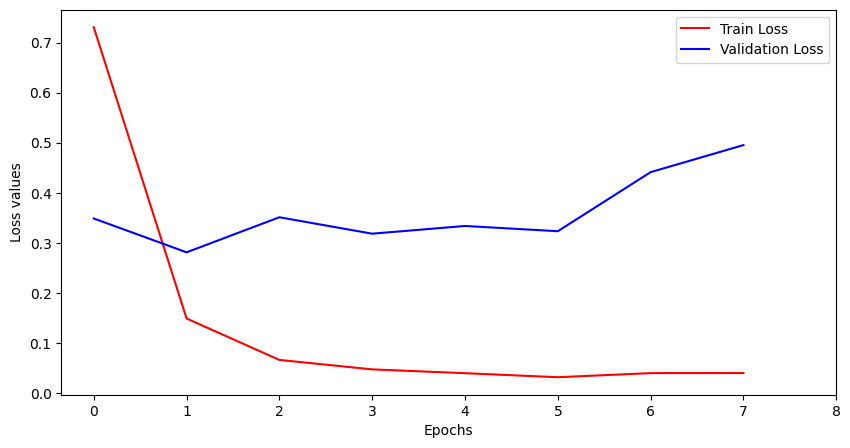

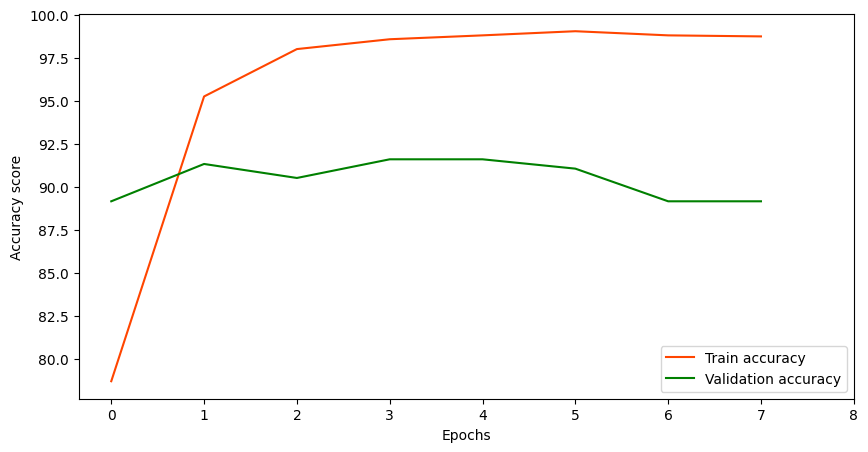

In [17]:
class PlotLearningcurves:
    
    def __init__(self, tr_loss, vl_loss, tr_acc, vl_acc):
        
        self.tr_loss, self.vl_loss, self.tr_acc, self.vl_acc = tr_loss, vl_loss, tr_acc, vl_acc

    def draw(self, array_1, array_2, label_1, label_2, color_1, color_2):
        
        plt.plot(array_1, label = label_1, c = color_1)
        plt.plot(array_2, label = label_2, c = color_2)

    def create_plot(self): plt.figure(figsize = (10, 5))

    def decorate(self, ylabel, xlabel = "Epochs"):
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(ticks = np.arange(len(self.tr_acc) +1), labels = [i for i in range(len(self.tr_acc) + 1)])
        plt.legend()
        plt.show()
    def demonstrate(self):
        self.create_plot()
        self.draw(array_1 = self.tr_loss, array_2 = self.vl_loss, label_1 = "Train Loss", label_2 = "Validation Loss", color_1 = 'red', color_2 = 'blue'); self.decorate(ylabel = "Loss values")

        self.create_plot()
        self.draw(array_1 = self.tr_acc, array_2 = self.vl_acc, label_1 = "Train accuracy", label_2 = "Validation accuracy", color_1 = "orangered", color_2 = "green"); self.decorate(ylabel = "Accuracy score")

PlotLearningcurves(tr_loss = trainer.train_losses, vl_loss = trainer.val_losses, tr_acc = trainer.train_acces, vl_acc = trainer.val_acces).demonstrate()

In [18]:
import random
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2, seaborn as sns
from sklearn.metrics import confusion_matrix
import random
import cv2
import seaborn as sns


In [19]:
class Denormalize:
    def __init__(self, mean, std):
        self.mean, self.std = mean, std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std): t.mul_(s).add_(m)
        return tensor

class Inference:
    def __init__(self, model, device, class_names, img_size = 224, mean = mean, std = std):
        self.denormalize = Denormalize(mean = mean, std=std)
        self.model = model
        self.model.eval()
        self.device = device
        self.class_names = class_names
        self.img_size = img_size

    def tensor_2_img(self, tensor):
        tensor = self.denormalize(tensor)
        tensor = tensor.permute(1,2,0)
        return (tensor.cpu().numpy() * 255).astype(np.uint8)

    def gradcam(self, pic):
        cam = GradCAMPlusPlus(self.model, target_layers = [self.model.features[-1]],  use_cuda = "cuda")
        final_cam = cam(pic.unsqueeze(0))[0, :]
        return final_cam

    def inference(self, model, ts_dl, num_of_pics, num_rows):
        images, predictions, prediction_classes, ground_truth = [], [], [], []
        accuracy, numbering = 0, 1
        with torch.no_grad():
            for idx, batch in tqdm(enumerate(ts_dl), desc = "Test process..."):
                pic, label = TrainValidation.to_device(batch = batch, device = self.device)
                pred = self.model(pic)
                pred_class = torch.argmax(pred, dim=1)
                accuracy += (pred_class == label).sum().item() 
                images.append(pic[0])
                predictions.append(pred[0])
                prediction_classes.append(pred_class[0].item())
                ground_truth.append(label[0].item())

            print(f"Test accuracy is ->  {(accuracy/len(ts_dl.dataset)) * 100:.2f}")

        plt.figure(figsize = (20,10))
        indexes = [random.randint(0, len(images) - 1) for _ in range(num_of_pics)]
        for idx, indeks in enumerate(indexes):
            
            pic = self.tensor_2_img(images[indeks].squeeze())
            pred_indeks = (prediction_classes[indeks])
            ground_truth_indeks = (ground_truth[indeks])

            plt.subplot(num_rows, num_of_pics // num_rows, numbering)
            numbering += 1
            plt.imshow(pic, cmap = "gray")
            plt.axis("off")

            cam_pic = self.gradcam(images[indeks])
            tablot = show_cam_on_image(pic / 255, cam_pic, image_weight = 0.4, use_rgb = True)
            plt.imshow(cv2.resize(tablot, (self.img_size, self.img_size), interpolation = cv2.INTER_LINEAR), alpha = 0.7, cmap = "jet")
            plt.axis("off")

            pred = predictions[indeks]
            if pred.dim() == 1: pred = pred.unsqueeze(0)

            if self.class_names:
                label_name = self.class_names[ground_truth_indeks]
                pred_name = self.class_names[pred_indeks]
                col = "green" if pred_name == label_name else "red"
                plt.title(f"Original image name - {label_name}; Prediction name - {pred_name}", color = col)
        plt.figure(figsize=(20, 10))   
        cm = confusion_matrix(ground_truth, prediction_classes)
        sns.heatmap(cm, annot=True, xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title("Confusion Matrix")
        plt.xlabel("Bashoratlar")
        plt.ylabel("Ground truths")
        plt.show()               




        

C:\Users\Nodir\AppData\Local\Temp\ipykernel_5440\2831428833.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model/_best_OxfordPet_

Test accuracy is ->  91.35


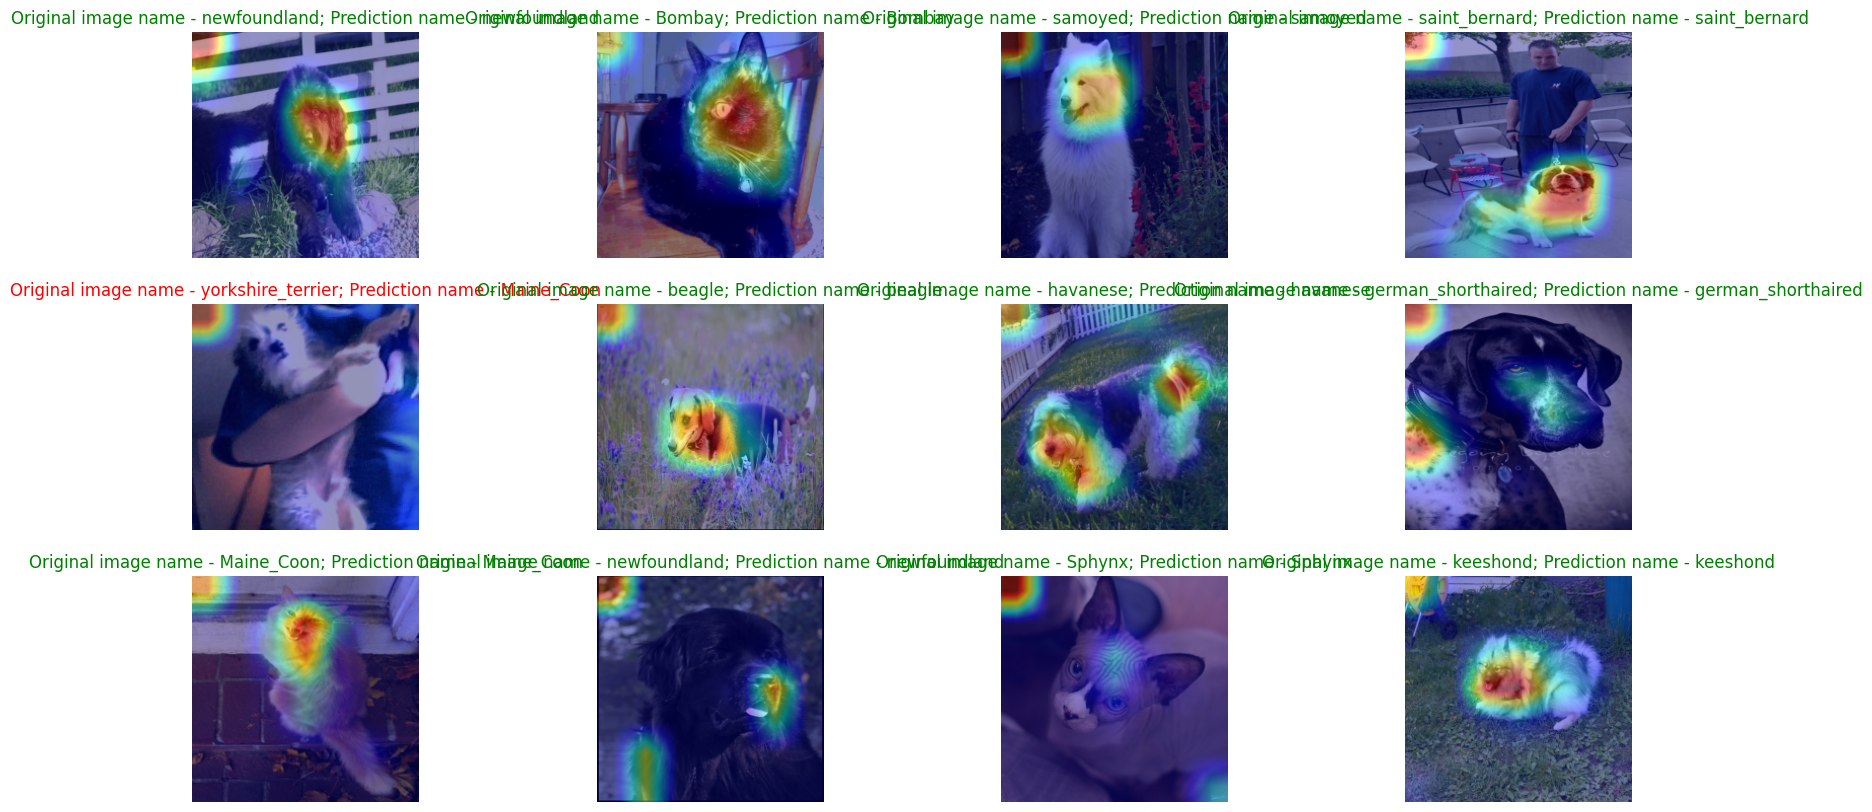

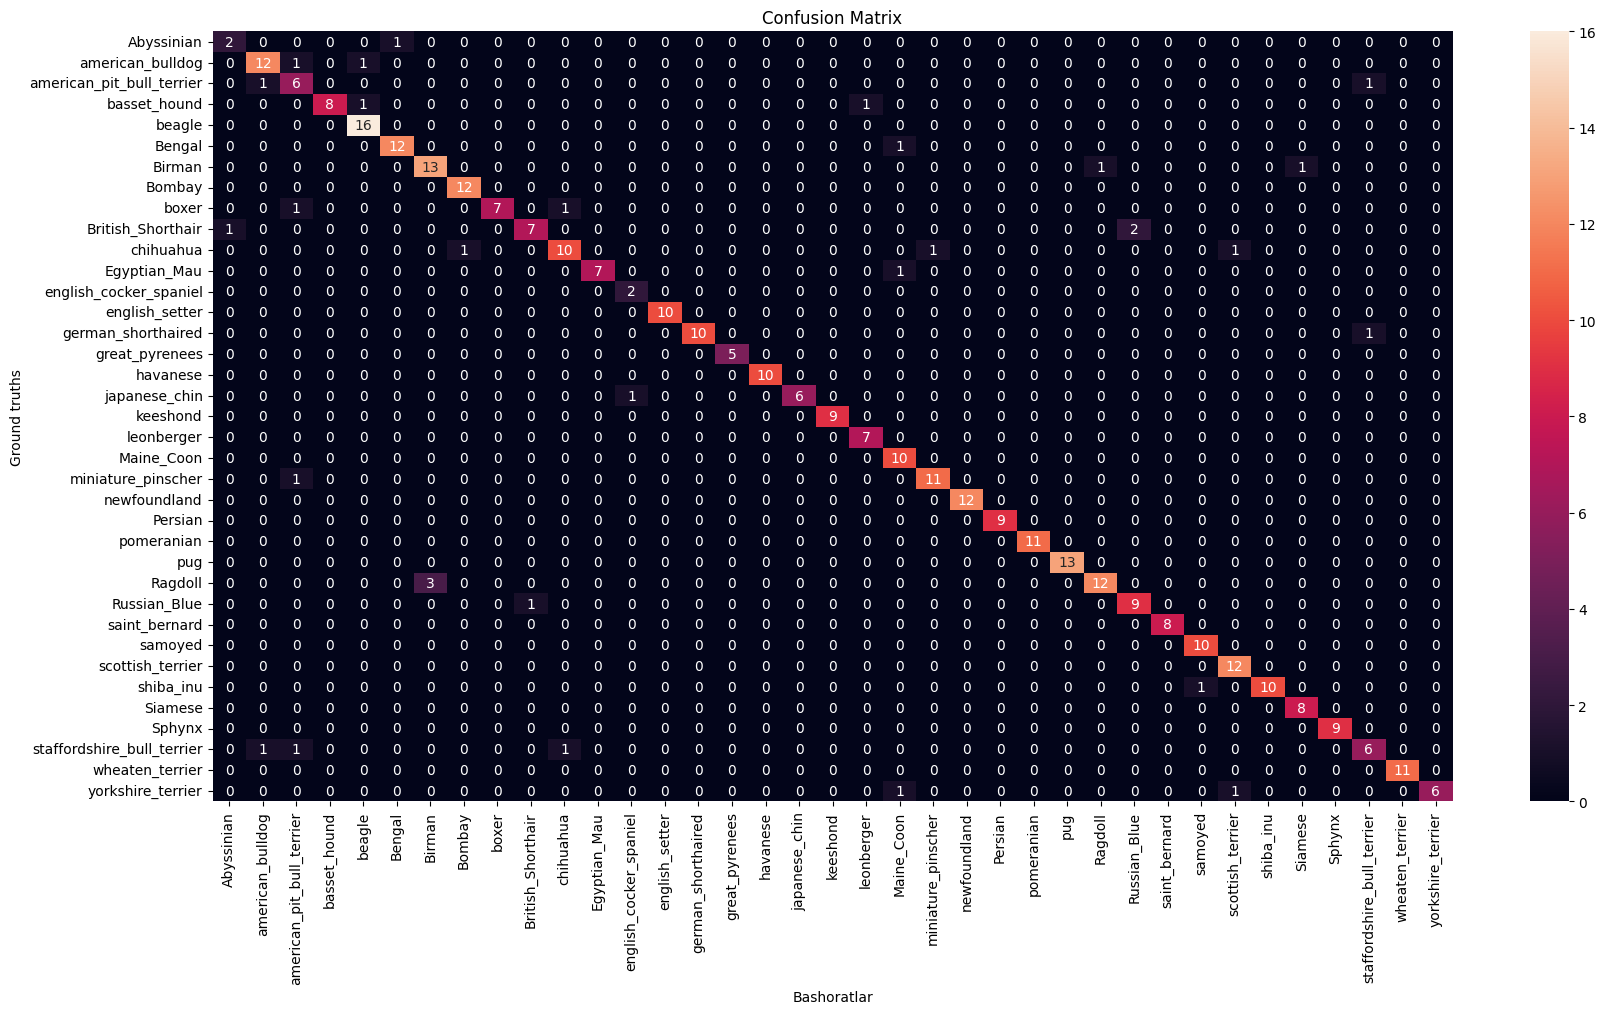

In [37]:
device = "cuda"
model = timm.create_model(model_name = "rexnet_150", pretrained = False, num_classes = len(class_names)).to(device)
model.load_state_dict(torch.load("best_model/_best_OxfordPet_model.pth"))
drawer = Inference(model=model, device=device, class_names=list(class_names.keys()), img_size=224)

drawer.inference(model= model, ts_dl = ts_dl, num_of_pics=12, num_rows=3)